In [74]:
####################################################
##                                                ##
##              Итоговая работа по ML             ##
##                                                ##
####################################################

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

def explore(dataframe):
    
    print("Total Records: ", dataframe.shape[0])
          
    
    x = dataframe.columns[dataframe.isnull().any()].tolist()   
    if not x:
        print("No Missing/Null Records")
    else:        
        print("Found Missing Records")

#Смотрим путь хама и спама(Подойдут любые форматы данных)
def msgs(path):
  data = []
  #path = 'content/'
  files = [f for f in os.listdir(path)]
  for file in files:
    with io.open(path+file, "r", errors='ignore') as f:
      data.append(f.read())
      
  return data



In [75]:
df_train_ham = pd.DataFrame({'Message': msgs('content/enron/ham/'), 'Category': 0})
df_train_spam = pd.DataFrame({'Message': msgs('content/enron/spam/'), 'Category': 1})

df = pd.concat([df_train_ham, df_train_spam], ignore_index=True)
print("Total: ", df.shape)
df.head()


Total:  (33701, 2)


,Message,Category
0,Subject: christmas tree farm pictures\n,0
1,Subject: re : rankings\nthank you .,0
2,Subject: leadership development pilot\nsally :...,0
3,Subject: key dates and impact of upcoming sap ...,0
4,Subject: key hr issues going forward\na ) year...,0


In [76]:
#Разведка данных(можно что-то добавить)
print("Total Number of spam messages in data: ", df[df['Category']==1].shape[0])
print("Total Number of non-spam messages in data: ", df[df['Category']==0].shape[0])

Total Number of spam messages in data:  17156
Total Number of non-spam messages in data:  16545


In [77]:
word_counts = df['Message'].apply(lambda x: len(x.split()))
word_counts.describe()

count    33701.000000
mean       311.659980
std        851.598957
min          1.000000
25%         72.000000
50%        154.000000
75%        331.000000
max      45451.000000
Name: Message, dtype: float64

In [78]:
explore(df)

Total Records:  33701
No Missing/Null Records


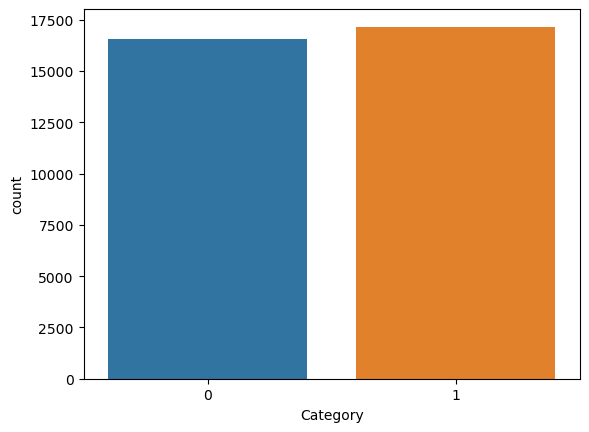

In [79]:
import seaborn as sns
sns.countplot(data=df, x="Category")
plt.show()

In [80]:
#Обработка
import re
import nltk
nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

my_stopwords = ["subject"]

stop_words = stopwords.words('english') 
stop_words.extend(my_stopwords)
stop_words.remove('not') 
lemmatizer = WordNetLemmatizer()

def data_preprocessing(Message):
    
  # Очиста от ненужного
  Message = re.sub(re.compile('<.*?>'), '', Message) 
  Message =  re.sub('[^A-Za-z0-9]+', ' ', Message) 
  Message = Message.lower()
  
  #Делаем токены
  tokens = nltk.word_tokenize(Message) 

  #Приводим к нормальной форме письма
  Message = [word for word in tokens if word not in stop_words]
  Message = [lemmatizer.lemmatize(word) for word in Message]
  Message = ' '.join(Message)
  
  return Message

df['Preprocessed_Message'] = df['Message'].apply(lambda Message: data_preprocessing(Message))
df.head()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Message,Category,Preprocessed_Message
0,Subject: christmas tree farm pictures\n,0,christmas tree farm picture
1,Subject: re : rankings\nthank you .,0,ranking thank
2,Subject: leadership development pilot\nsally :...,0,leadership development pilot sally timing ask ...
3,Subject: key dates and impact of upcoming sap ...,0,key date impact upcoming sap implementation ne...
4,Subject: key hr issues going forward\na ) year...,0,key hr issue going forward year end review rep...


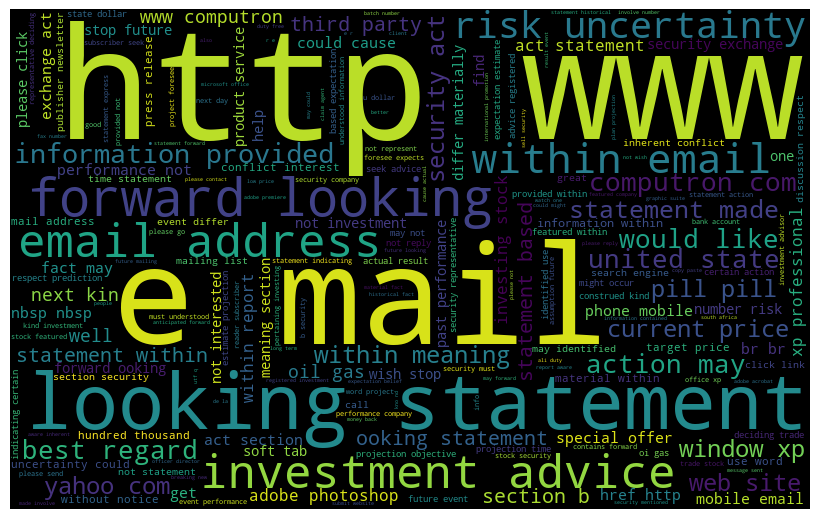

In [81]:
from wordcloud import WordCloud

#Позитивные слова(т.е. те что не могут встречатся в спам письмах)
words_list = df[df['Category']==1]['Preprocessed_Message'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

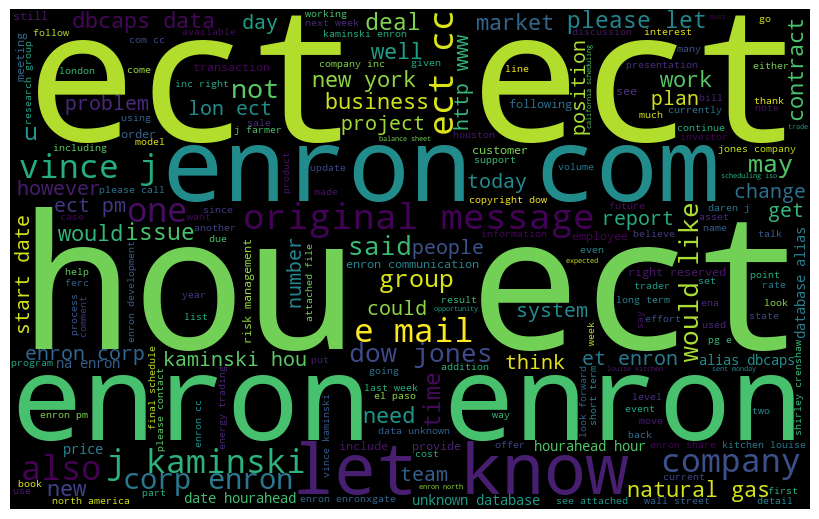

In [82]:
#Спам слова
words_list = df[df['Category']==0]['Preprocessed_Message'].unique().tolist()
neg_words = " ".join(words_list)

neg_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(neg_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [136]:
#Сплит на тест и треин данные
from sklearn.model_selection import train_test_split

data = df.copy()
y = data['Category'].values
data.drop(['Category'], axis=1, inplace=True)

X_train, X_test, y_train, y_train = train_test_split(data, y, test_size=0.9, stratify=y, random_state=30)

print("Train data:", y_train.shape)

Train data: (30331,)


In [158]:
#Считаем BOW
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=3500)

X_train_message_bow = vect.fit_transform(X_test['Preprocessed_Message'])

print('X_train_message_bow shape: ', X_train_message_bow.shape)

X_train_message_bow shape:  (30331, 46)


In [161]:
#Считаем TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=3500)

X_train_message_tfidf = vect.fit_transform(X_test['Preprocessed_Message'])

print('X_train_message_tfidf shape: ', X_train_message_tfidf.shape)

X_train_message_tfidf shape:  (30331, 46)


In [162]:
#теорема Байса(Наивный Байс) через BOW
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

clf = MultinomialNB()
clf.fit(X_train_message_bow, y_train)

y_pred = clf.predict(X_train_message_bow) #prediction from model

NB_BOW_AS = accuracy_score(y_train, y_pred)
NB_BOW_PS = precision_score(y_train, y_pred)
NB_BOW_RS = recall_score(y_train, y_pred)
print('Test Accuracy: ', NB_BOW_AS)
print('Test Precision: ', NB_BOW_PS)
print('Test Recall: ', NB_BOW_RS) 

Test Accuracy:  0.8519666347960833
Test Precision:  0.8028878070369551
Test Recall:  0.9399611398963731


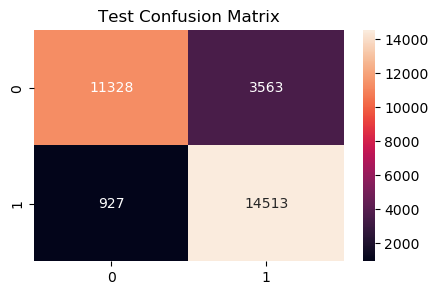

In [163]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [164]:
#теорема Байса(Наивный Байс) через TFIDF
clf = MultinomialNB(alpha=1)
clf.fit(X_train_message_tfidf, y_train)

y_pred = clf.predict(X_train_message_tfidf)
NB_TFIDF_AS = accuracy_score(y_train, y_pred)
NB_TFIDF_PS = precision_score(y_train, y_pred)
NB_TFIDF_RS = recall_score(y_train, y_pred)
print('Test Accuracy: ', NB_TFIDF_AS)
print('Test Precision: ', NB_TFIDF_PS)
print('Test Recall: ', NB_TFIDF_RS)

Test Accuracy:  0.8519666347960833
Test Precision:  0.8028878070369551
Test Recall:  0.9399611398963731


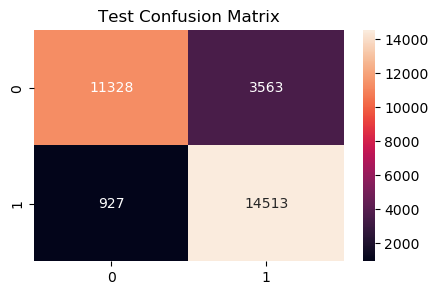

In [165]:
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [166]:
#Лог регрессия через TFIDF
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

clf = LogisticRegression(penalty='l2')
clf.fit(X_train_message_tfidf, y_train)

y_pred = clf.predict(X_train_message_tfidf)

LR_TFIDF_AS = accuracy_score(y_train, y_pred)
LR_TFIDF_PS = precision_score(y_train, y_pred)
LR_TFIDF_RS = recall_score(y_train, y_pred)
print('Test Accuracy: ', LR_TFIDF_AS)
print('Test Precision: ', LR_TFIDF_PS)
print('Test Recall: ', LR_TFIDF_RS)

Test Accuracy:  0.8735617025485477
Test Precision:  0.8284371992981264
Test Recall:  0.9479274611398963


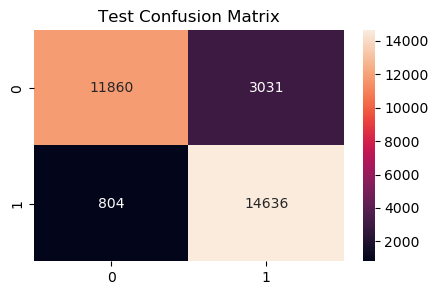

In [167]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [168]:
#Все результаты исследования
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorizer', 'Model', 'Accuracy', 'Precision', 'Recall']
x.add_row(['BOW', 'Naive Bayes', NB_BOW_AS, NB_BOW_PS, NB_BOW_RS])
x.add_row(['TFIDF', 'Naive Bayes', NB_TFIDF_AS, NB_TFIDF_PS, NB_TFIDF_RS])
x.add_row(['TFIDF', 'Logistic Regression', LR_TFIDF_AS, LR_TFIDF_PS, LR_TFIDF_PS])
print(x)

+------------+---------------------+--------------------+--------------------+--------------------+
| Vectorizer |        Model        |      Accuracy      |     Precision      |       Recall       |
+------------+---------------------+--------------------+--------------------+--------------------+
|    BOW     |     Naive Bayes     | 0.8519666347960833 | 0.8028878070369551 | 0.9399611398963731 |
|   TFIDF    |     Naive Bayes     | 0.8519666347960833 | 0.8028878070369551 | 0.9399611398963731 |
|   TFIDF    | Logistic Regression | 0.8735617025485477 | 0.8284371992981264 | 0.8284371992981264 |
+------------+---------------------+--------------------+--------------------+--------------------+


In [169]:
#Тестирование на .eml
df_teacher_test_ham = pd.DataFrame({'Message': msgs('content/teachertest/ham/'), 'Category': 0})
df_teacher_test_spam = pd.DataFrame({'Message': msgs('content/teachertest/spam/'), 'Category': 1})

df_test = pd.concat([df_teacher_test_ham, df_teacher_test_spam], ignore_index=True)
print("Total: ", df_test.shape)
df_test.head()

Total:  (1594, 2)


,Message,Category
0,From spamassassin-talk-admin@lists.sourceforge...,0
1,From spamassassin-talk-admin@lists.sourceforge...,0
2,From fork-admin@xent.com Tue Sep 24 10:48:34 ...,0
3,From fork-admin@xent.com Thu Sep 19 13:14:49 ...,0
4,From spamassassin-talk-admin@lists.sourceforge...,0


In [170]:
print("Total Number of spam messages in data: ", df_test[df_test['Category']==1].shape[0])
print("Total Number of non-spam messages in data: ", df_test[df_test['Category']==0].shape[0])

Total Number of spam messages in data:  994
Total Number of non-spam messages in data:  600


In [171]:

df_test['Preprocessed_Message'] = df_test['Message'].apply(lambda Message: data_preprocessing(Message))
df_test.head()

,Message,Category,Preprocessed_Message
0,From spamassassin-talk-admin@lists.sourceforge...,0,spamassassin talk admin list sourceforge net t...
1,From spamassassin-talk-admin@lists.sourceforge...,0,spamassassin talk admin list sourceforge net t...
2,From fork-admin@xent.com Tue Sep 24 10:48:34 ...,0,fork admin xent com tue sep 24 10 48 34 2002 r...
3,From fork-admin@xent.com Thu Sep 19 13:14:49 ...,0,fork admin xent com thu sep 19 13 14 49 2002 r...
4,From spamassassin-talk-admin@lists.sourceforge...,0,spamassassin talk admin list sourceforge net w...


In [172]:
from sklearn.model_selection import train_test_split

data = df_test.copy()
y = data['Category'].values
data.drop(['Category'], axis=1, inplace=True)

X_test, X_train, y_test, y_train= train_test_split(data, y, test_size=0.01, stratify=y, random_state=30)

print("Test data:",  X_test.shape, y_test.shape)

Test data: (1578, 2) (1578,)


In [177]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=10)

X_train_message_bow = vect.fit_transform(X_train['Preprocessed_Message'])
X_test_message_bow = vect.transform(X_test['Preprocessed_Message'])

print('X_test_message_bow shape: ', X_test_message_bow.shape)

X_test_message_bow shape:  (1578, 24)


In [178]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10)

X_train_message_tfidf = vectorizer.fit_transform(X_train['Preprocessed_Message'])
X_test_message_tfidf = vectorizer.transform(X_test['Preprocessed_Message'])

print('X_test_message_tfidf shape: ', X_test_message_tfidf.shape)

X_test_message_tfidf shape:  (1578, 24)


In [179]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

clf = MultinomialNB()
clf.fit(X_train_message_bow, y_train)

y_pred = clf.predict(X_test_message_bow) #prediction from model

NB_BOW_AS = accuracy_score(y_test, y_pred)
NB_BOW_PS = precision_score(y_test, y_pred)
NB_BOW_RS = recall_score(y_test, y_pred)
print('Test Accuracy: ', NB_BOW_AS)
print('Test Precision: ', NB_BOW_PS)
print('Test Recall: ', NB_BOW_RS) 

Test Accuracy:  0.6951837769328264
Test Precision:  0.8261997405966277
Test Recall:  0.6473577235772358


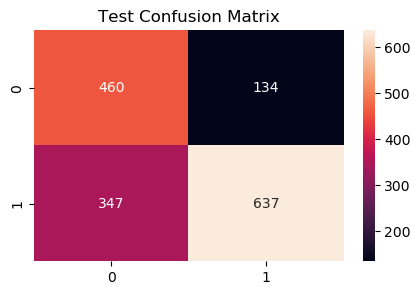

In [180]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [181]:
clf = MultinomialNB(alpha=1)
clf.fit(X_train_message_tfidf, y_train)

y_pred = clf.predict(X_test_message_tfidf)
NB_TFIDF_AS = accuracy_score(y_test, y_pred)
NB_TFIDF_PS = precision_score(y_test, y_pred)
NB_TFIDF_RS = recall_score(y_test, y_pred)
print('Test Accuracy: ', NB_TFIDF_AS)
print('Test Precision: ', NB_TFIDF_PS)
print('Test Recall: ', NB_TFIDF_RS)

Test Accuracy:  0.6204055766793409
Test Precision:  0.624113475177305
Test Recall:  0.983739837398374


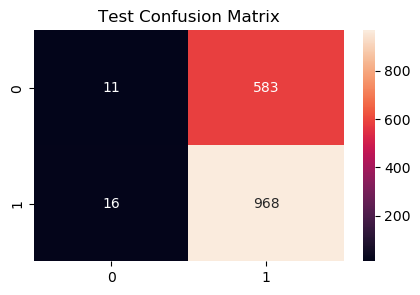

In [102]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [186]:
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

clf = LogisticRegression(penalty='l2')
clf.fit(X_train_message_tfidf, y_train)

y_pred = clf.predict(X_test_message_tfidf)

LR_TFIDF_AS = accuracy_score(y_test, y_pred)
LR_TFIDF_PS = precision_score(y_test, y_pred)
LR_TFIDF_RS = recall_score(y_test, y_pred)
print('Test Accuracy: ', LR_TFIDF_AS)
print('Test Precision: ', LR_TFIDF_PS)
print('Test Recall: ', LR_TFIDF_RS)

Test Accuracy:  0.6280101394169835
Test Precision:  0.6325985303941216
Test Recall:  0.9623983739837398


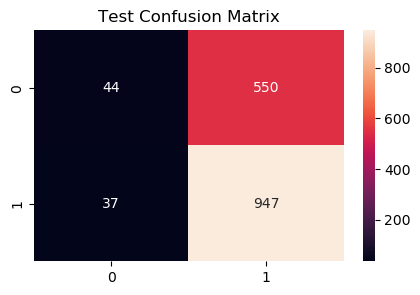

In [183]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [184]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorizer', 'Model', 'Accuracy', 'Precision', 'Recall']
x.add_row(['BOW', 'Naive Bayes', NB_BOW_AS, NB_BOW_PS, NB_BOW_RS])
x.add_row(['TFIDF', 'Naive Bayes', NB_TFIDF_AS, NB_TFIDF_PS, NB_TFIDF_RS])
x.add_row(['TFIDF', 'Logistic Regression', LR_TFIDF_AS, LR_TFIDF_PS, LR_TFIDF_PS])
print(x)

+------------+---------------------+--------------------+--------------------+--------------------+
| Vectorizer |        Model        |      Accuracy      |     Precision      |       Recall       |
+------------+---------------------+--------------------+--------------------+--------------------+
|    BOW     |     Naive Bayes     | 0.6951837769328264 | 0.8261997405966277 | 0.6473577235772358 |
|   TFIDF    |     Naive Bayes     | 0.6204055766793409 | 0.624113475177305  | 0.983739837398374  |
|   TFIDF    | Logistic Regression | 0.6280101394169835 | 0.6325985303941216 | 0.6325985303941216 |
+------------+---------------------+--------------------+--------------------+--------------------+
